In [350]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
from acoustic_entrainment import VelocityResponse, muflown_response, muflown_sensitivity, mic_response
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from brownian import abc_guess, get_krhoA, psd_func, logbin_func, get_sound_speed
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

from os import path

from matplotlib import rc
fontsize = 5
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    "text.latex.preamble":
        r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    "font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.4,
    'xtick.minor.width': 0.4,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.4,
    'ytick.minor.width': 0.4,
    "axes.linewidth": 0.4,
}
plt.rcParams.update(fontstyle)

# New function definitions

In [351]:
def sort_fnames(fnames, include=None, exclude=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    if exclude is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr not in exclude]
    return fnames_sorted

from constants import kB
from scipy.integrate import cumulative_trapezoid

reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

def psd_calibration(fname, channel="X",
                   fmin=5e2, fmax=4e4, cutoff=1e6,  taumax=100e-3,freq_xnoise2=2e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    C = Collection(fname)
    C.set_collection(channel)
    Tavg = np.mean(C.T)
    if Tavg < 273.15:
        Tavg += 273.15
    Npts = int(C.r / (2*cutoff))
    C.apply("detrend", inplace=True, mode="constant")
    #C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    cal_params = get_params_from_abcRT(*abc, C.R, Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>freq_xnoise2])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker="o", ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq[1:], plot_psd[1:], **dplot_kwargs)
        
        fplot_kwargs = dict(c=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        #ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

def deg2rad(x):
    return x * np.pi / 180


def rad2deg(x):
    return x * 180 / np.pi

def radian_labels(ax, denoms=[-1, -2, 0, 2, 1], skip=1):
    rads = [np.pi/d if d!=0 else 0 for d in denoms]
    rad_labels = [r"$-\pi/%s$" % abs(d) if d<-1 \
             else r"$\pi/%s$" % abs(d) if d>1 \
             else "$-\pi$" if d == -1 \
             else "$\pi$" if d == 1 \
             else "$0$" for d in denoms]
    return rads, rad_labels
    

def dB_re(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return deci * np.log10(x/ref)

def db_re_inverse(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return ref * 10**(x/deci)


def SPL(x):
    return dB_re(x, ref=20e-6, typ="pressure")


def slope(x, m):
    return x/m

def line(x, speed, x0):
    return (x-x0)/speed

def slope_quad(x, a, b):
    return a*x + b*x*x

def powerlaw(x, a, m):
    return a * x**m

def exponential(x, a, m):
    return a * np.e**(x/m)

def find_pulse_points(time_series, tmin, tmax, factor=0.0, nozeros=False): 
    ts, xs = time_series.time_gate(tmin, tmax)
    # trough
    troughdex = np.argmin(xs)
    ttrough = ts[troughdex]
    xtrough = xs[troughdex]
    #peak
    peakdex = np.argmax(xs[ts<ttrough])
    tpeak = ts[ts<ttrough][peakdex]
    xpeak = xs[ts<ttrough][peakdex]
    if nozeros:
        tpoints = [0, tpeak, 0, ttrough, 0]
        xpoints = [0, xpeak, 0, xtrough, 0]
        return tpoints, xpoints
        
    # zeros
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xpeak)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    ## left
    peak_minus_zeros = tpeak - tzeros
    left_zeros_mask = peak_minus_zeros > 0
    left_zero = tzeros[left_zeros_mask][np.argmin(peak_minus_zeros[left_zeros_mask])]
    ## right
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xtrough)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    zeros_minus_trough = tzeros - ttrough
    right_zeros_mask =  zeros_minus_trough > 0
    right_zero = tzeros[right_zeros_mask][np.argmin(zeros_minus_trough[right_zeros_mask])]
    ## middle
    pre_zerodex = np.where(np.diff(np.sign(xs)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    mid_zero = tzeros[np.logical_and(tzeros>tpeak, tzeros<ttrough)][0]
    # important points
    tpoints = [left_zero, tpeak, mid_zero, ttrough, right_zero]
    xpoints = [factor*xpeak, xpeak, 0, xtrough, factor*xtrough]
    return tpoints, xpoints




def make_musphere_response(C0, impedance=None, r0=3e-2, response="bassetbound"):
    T = np.mean(C0.T)
    VR = VelocityResponse(1/C0.cal, C0.R, C0.rho, T, C0.cRH, C0.k)
    if impedance is None:
        _response = lambda f:VR.response(response, f)
    else:
        impedance = getattr(VR, f"{impedance}_impedance")
        _response = lambda f:VR.response(response, f)/impedance(f, r0)
    return _response

def load_collection(fname, channel, response, differentiate, 
                    scale=1, cutoff=None, Npts="cutoff", shift=0, invert=False, 
                    tmin=None, tmax=None, window="boxcar", detrend="constant"):
    C = Collection(fname)
    C.set_collection(channel)
    C.apply("calibrate", cal=scale, inplace=True)
    if cutoff is not None:
        C.apply("lowpass", cutoff=cutoff, inplace=True)
    if Npts is not None:
        if Npts == "cutoff":
            if cutoff is not None:
                Npts=int(C.r/(2*cutoff))
            else:
                Npts = None
        C.apply("bin_average", Npts=Npts, inplace=True)
    if response is not None:
        C.apply("correct", response=response, n_jobs=1, tmin=tmin, tmax=tmax, 
            window=window, differentiate=differentiate, recollect=True)
    if response is None and differentiate:
        C.apply("differentiate", inplace=True)
        
    if detrend is not None:
        C.apply("detrend", mode=detrend, inplace=True)
    C.apply("shift", tau=shift, inplace=True)
    if invert:
        C.apply("calibrate", cal=-1, inplace=True)
    return C

# Directory structure

In [199]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20220707',
 '/data/brownian/20211215',
 '/data/brownian/20220720',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20220525',
 '/data/brownian/20220614',
 '/data/brownian/20220628',
 '/data/brownian/20220726',
 '/data/brownian/20220722',
 '/data/brownian/20220715',
 '/data/brownian/20220523']

In [19]:
# Select a date
date_der_index = 8
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20220726/bead1']

In [6]:
# Select a date
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20220726/bead1/slow-50x-flown_4kHz-CW-V7_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2',
 '/data/brownian/20220726/bead1/slow-phone_40kHz-N10-V9-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-phone_40kHz-CW-V9_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_4kHz-CW-V7_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_4kHz-N3-V6-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-flown-Z50_baseline_1',
 '/data/brownian/20220726/bead1/slow-50x-flown_baseline_3',
 '/data/brownian/20220726/bead1/slow-phone_baseline_1',
 '/data/brownian/20220726/bead1/slow-50x-flown_4kHz-N3-V6-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-CW-V9_fos-scan-wide',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-N10-V9-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-50x-flown_baseline_2',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-CW-V9_fos-scan',
 '/data/brownian/20220726/bead1

# Bead calibration

In [9]:
baseline_experiment_index = [1,6,7,8,12]
baseline_fnames = sort_fnames(find_files(experiment_ders[baseline_experiment_index[0]]))
for experiment_der_index in baseline_experiment_index[1:]:
    next_fnames = sort_fnames(find_files(experiment_ders[experiment_der_index]))
    for fname in next_fnames:
        baseline_fnames.append(fname)

In [10]:
baseline_fnames

['/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_0.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_1.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_2.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_3.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_4.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_5.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_6.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_7.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_8.tdms',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2/iter_9.tdms',
 '/data/brownian/20220726/bead1/slow-flown-Z50_baseline_1/iter_0.tdms',
 '/data/brownian/20220726/bead1/slow-flown-Z50_baseline_1/iter_1.tdms',
 '/data/brownian/20220726/bead1/slow-flown-Z50_baseline_1/iter_2.tdms',
 '/data/brownian/20220726/bead1/slow-flown-Z50_baseline_1/iter_3.tdms',
 '/data/brownian/20220726/bead1/

0 50
1 50
2 50
3 50
4 50
5 50
6 50
7 50
8 50
9 50
10 50
11 50
12 50
13 50
14 50
15 50
16 50
17 50
18 50
19 50
20 50
21 50
22 50
23 50
24 50
25 50
26 50
27 50
28 50
29 50
30 50
31 50
32 50
33 50
34 50
35 50
36 50
37 50
38 50
39 50
40 50
41 50
42 50
43 50
44 50
45 50
46 50
47 50
48 50
49 50


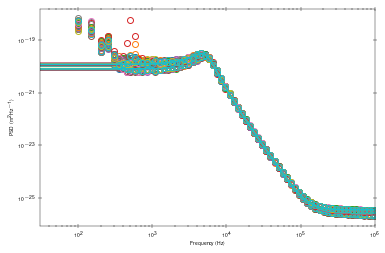

In [20]:
fmin = 1e3
fmax = 3e4
cutoff = 1000e3
taumax = 20e-3

fig, ax = plt.subplots(1,1, figsize=(6,4))

krhoCalTs = []
for fnamei, fname in enumerate(baseline_fnames):
    print(fnamei, len(baseline_fnames))
    color = f"C{fnamei}"
    C0, ax = psd_calibration(fname, taumax=taumax, fmin=fmin, fmax=fmax, cutoff=cutoff, 
                             plot=True, ax=ax, color=color)
    krhoCalTs.append([C0.k, C0.rho, C0.cal, C0.Tavg, np.mean(C0.PDF), np.mean(C0.PDB)])    
krhoCalTs = np.array(krhoCalTs)

In [31]:
C0.Navg_psd

80

k : 28.78321802369068 2.7919335637180573 9.699865947650792
rho : 1525.239056833586 32.79479076223956 2.150141029716478
cal : 0.249658287925231 0.02318763182134369 9.287747670643341
T : 23.33557938794027 0.14387315407403953 0.616539883935312
P : 93.88991163172281 0.4439925231030775 0.47288629351853034


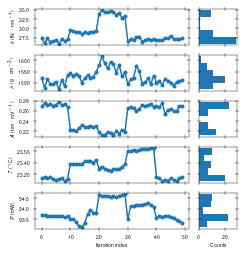

In [41]:
fig, axs = plt.subplots(5,2, figsize=(3.375, 3.5), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", 
           r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$", r"$P~{\rm (mW)}$"]

for parami, param in enumerate(["k", "rho", "cal", "T", "P"]):
    vals = krhoCalTs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="cal":
        vals = vals * 1e9 / 1e3
    if param == "T":
        vals = vals -273.15
    if param == "P":
        vals =krhoCalTs[:, parami]+krhoCalTs[:, parami+1]
    
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=5, orientation="horizontal")
    # labels
    axs[parami, 0].set_ylabel(ylabels[parami])
    axs[-1, 0].set_xlabel("Iteration index")
    axs[-1, 1].set_xlabel("Counts")
    
    axs[parami, 0].yaxis.set_major_locator(ticker.MaxNLocator(4))
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))
plt.tight_layout()
R = C0.R
plt.savefig("figures/calibration_summary_20220726.pdf")
plt.savefig("figures/calibration_summary_20220726.png", dpi=600)

In [45]:
laser_delay = 1000e-6
pos0 = 4.4
c0 = get_sound_speed(T=C0.Tavg, RH=C0.cRH, p=C0.cP)

In [46]:
experiment_ders

['/data/brownian/20220726/bead1/slow-50x-flown_4kHz-CW-V7_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2',
 '/data/brownian/20220726/bead1/slow-phone_40kHz-N10-V9-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-phone_40kHz-CW-V9_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_4kHz-CW-V7_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_4kHz-N3-V6-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-flown-Z50_baseline_1',
 '/data/brownian/20220726/bead1/slow-50x-flown_baseline_3',
 '/data/brownian/20220726/bead1/slow-phone_baseline_1',
 '/data/brownian/20220726/bead1/slow-50x-flown_4kHz-N3-V6-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-CW-V9_fos-scan-wide',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-N10-V9-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-50x-flown_baseline_2',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-CW-V9_fos-scan',
 '/data/brownian/20220726/bead1

In [116]:
flown_sty = {"c": "darkcyan", "marker": ">"}
phone_sty = {"c": "darkgoldenrod", "marker": "s"}
sphere_sty = {"c": "maroon", "marker": "o"}

In [340]:
Cfl.Nrecords

100

/data/brownian/20220726/bead1/slow-50x-flown_40kHz-N10-V9-resonant-burst-pos-scan/iter_0.tdms /data/brownian/20220726/bead1/slow-phone_40kHz-N10-V9-resonant-burst-pos-scan/iter_0.tdms
/data/brownian/20220726/bead1/slow-50x-flown_4kHz-N3-V6-resonant-burst-pos-scan/iter_0.tdms /data/brownian/20220726/bead1/slow-phone_4kHz-N3-V6-resonant-burst-pos-scan/iter_0.tdms


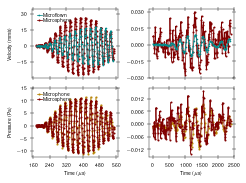

In [409]:
tmin= 175e-6
tmax = 550e-6
cutoff_bd = 500e3
posi=0
Navg = 1
window = "boxcar"

fig, axs = plt.subplots(2, 2, figsize=(3.375, 2.5), sharex="col")

fname_fl = sort_fnames(find_files(experiment_ders[-4]))[posi]
fname_ph = sort_fnames(find_files(experiment_ders[2]))[posi]
print(fname_fl, fname_ph)

musphere_response_v = make_musphere_response(C0, response="bassetbound", impedance=None)
musphere_response_p = make_musphere_response(C0, response="bassetbound", impedance="plane")

Cfl = load_collection(fname_fl, "Y", muflown_response, scale=1/50,
                          differentiate=False, cutoff=200e3, Npts="cutoff", shift=laser_delay+22.5e-6, invert=False)
Cfl.aggrigate()
Cfl.agg.plot(ax=axs[0,0], tmin=tmin, tmax=tmax, unit="mm_s", tunit="us", zorder=2,
                ms=1, lw=0.75, label=f"Microflown", **flown_sty)

Cbd_fl = load_collection(fname_fl, "X", musphere_response_v,window=window, tmin=0, tmax=5000e-6,
                          differentiate=True, cutoff=cutoff_bd, Npts="cutoff", shift=laser_delay, invert=False)
Cbd_fl.aggrigate()
Cbd_fl.agg.plot(ax=axs[0,0], tmin=tmin, tmax=tmax, unit="mm_s", tunit="us", zorder=0,
                ms=1, lw=0.75, label=f"Microsphere", **sphere_sty)


Cph = load_collection(fname_ph, "Y", mic_response, 
                          differentiate=False, cutoff=200e3, Npts="cutoff", shift=laser_delay+14.5e-6, invert=False)
Cph.aggrigate()
Cph.agg.plot(ax=axs[1,0], tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
                ms=1, lw=0.75, label=f"Microphone", **phone_sty)

Cbd_ph = load_collection(fname_ph, "X", musphere_response_p, window=window, tmin=0, tmax=5000e-6,
                          differentiate=True, cutoff=cutoff_bd, Npts="cutoff", shift=laser_delay, invert=False)
Cbd_ph.aggrigate()
Cbd_ph.agg.plot(ax=axs[1,0], tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
                ms=1, lw=0.75, label=f"Microsphere", **sphere_sty)


tmin= 0e-6
tmax = 2400e-6
cutoff_bd = 50e3


fname_fl = sort_fnames(find_files(experiment_ders[-6]))[posi]
fname_ph = sort_fnames(find_files(experiment_ders[5]))[posi]
print(fname_fl, fname_ph)


Cfl = load_collection(fname_fl, "Y", muflown_response, scale=1/50,
                          differentiate=False, cutoff=25e3, Npts="cutoff", shift=laser_delay-50e-6, invert=False)
Cfl.aggrigate(collection_slice=Cfl.Nrecords-Navg)
Cfl.agg.plot(ax=axs[0,1], tmin=tmin, tmax=tmax, unit="mm_s", tunit="us", zorder=2,
                ms=1, lw=0.75, label=f"Microflown", **flown_sty)

Cbd_fl = load_collection(fname_fl, "X", musphere_response_v, window=window, tmin=0, tmax=5000e-6,
                          differentiate=True, cutoff=cutoff_bd, Npts="cutoff", shift=laser_delay, invert=False)
Cbd_fl.aggrigate(collection_slice=Cfl.Nrecords-Navg)
Cbd_fl.agg.plot(ax=axs[0,1], tmin=tmin, tmax=tmax, unit="mm_s", tunit="us", zorder=0,
                ms=1, lw=0.75, label=f"Microsphere", **sphere_sty)


Cph = load_collection(fname_ph, "Y", mic_response,
                          differentiate=False, cutoff=25e3, Npts="cutoff", shift=laser_delay-80e-6, invert=False)
Cph.aggrigate(collection_slice=Cfl.Nrecords-Navg)
Cph.agg.plot(ax=axs[1,1], tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
                ms=1, lw=0.75, label=f"Microphone", **phone_sty)

Cbd_ph = load_collection(fname_ph, "X", musphere_response_p, window=window, tmin=0, tmax=5000e-6,
                          differentiate=True, cutoff=cutoff_bd, Npts="cutoff", shift=laser_delay, invert=False)
Cbd_ph.aggrigate(collection_slice=Cfl.Nrecords-Navg)
Cbd_ph.agg.plot(ax=axs[1,1], tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
                ms=1, lw=0.75, label=f"Microsphere", **sphere_sty)


for ax in (axs[0,0], axs[0,1]):
    ax.set_xlabel(None)
    
for axr in axs:
    for ax in axr:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(6))

axs[1,0].set_ylabel("Pressure (Pa)")
axs[1,1].set_ylabel(None)
axs[0,0].set_ylabel("Velocity (mm/s)")
axs[0,1].set_ylabel(None)
axs[0,0].set_ylim(top=35)
axs[1,0].set_ylim(top=15)
axs[0,0].legend(loc="upper left", frameon=False, handlelength=1, handletextpad=0.3, 
                labelspacing=0, columnspacing=0.5, ncol=1)
axs[1,0].legend(loc="upper left", frameon=False, handlelength=1, handletextpad=0.3, 
                labelspacing=0, columnspacing=0.5, ncol=1)
plt.tight_layout()
plt.savefig("figures/tone_burst_compare_1shot.pdf")
plt.savefig("figures/tone_burst_compare_1shot.png", dpi=600)

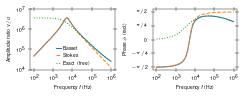

In [437]:
fig, axs = plt.subplots(1,2, figsize=(3.375, 1.3), sharex=True)
fs = np.geomspace(1e2, 1e6,1000)
for response, label, ls in zip(("bassetbound", "stokesbound", "exact"), ("Basset", "Stokes", "Exact (free)"), ("-", "--", ":")):
    musphere_response = make_musphere_response(C0, response=response, impedance=None)
    axs[0].loglog(fs,np.abs(musphere_response(fs)), ls=ls, lw=1, label=label)
    axs[1].semilogx(fs, np.arctan(np.imag(musphere_response(fs))/np.real(musphere_response(fs))), ls=ls, lw=1, label=label)
    
axs[0].set_ylabel(r"Amplitude ratio $v/u$")
axs[1].set_ylabel(r"Phase $\phi$ (rad.)")
axs[0].set_xlabel("Frequency $f$ (Hz)")
axs[1].set_xlabel("Frequency $f$ (Hz)")
axs[0].set_xticks([1e2, 1e3, 1e4, 1e5, 1e6])
axs[1].set_xticks([1e2, 1e3, 1e4, 1e5, 1e6])
axs[0].set_yticks([1e4, 1e5, 1e6, 1e7])
axs[0].minorticks_off()
axs[1].set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
axs[1].set_yticklabels([r"$-\pi/2$", r"$-\pi/4$", 0, r"$\pi/4$", r"$\pi/2$"])
axs[0].legend(frameon=False, handlelength=1, handletextpad=0.5)


plt.tight_layout()
plt.savefig("figures/transfer_function.pdf")
plt.savefig("figures/transfer_function.png", dpi=600)

In [285]:
experiment_ders

['/data/brownian/20220726/bead1/slow-50x-flown_4kHz-CW-V7_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_baseline_2',
 '/data/brownian/20220726/bead1/slow-phone_40kHz-N10-V9-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-phone_40kHz-CW-V9_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_4kHz-CW-V7_fos-scan',
 '/data/brownian/20220726/bead1/slow-phone_4kHz-N3-V6-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-flown-Z50_baseline_1',
 '/data/brownian/20220726/bead1/slow-50x-flown_baseline_3',
 '/data/brownian/20220726/bead1/slow-phone_baseline_1',
 '/data/brownian/20220726/bead1/slow-50x-flown_4kHz-N3-V6-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-CW-V9_fos-scan-wide',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-N10-V9-resonant-burst-pos-scan',
 '/data/brownian/20220726/bead1/slow-50x-flown_baseline_2',
 '/data/brownian/20220726/bead1/slow-50x-flown_40kHz-CW-V9_fos-scan',
 '/data/brownian/20220726/bead1

In [453]:
def load_many_psd(fnames, X_load_params, Y_load_params, scan_var="fos", taumax=None):
    CXs = np.zeros(len(fnames), dtype="object")
    CYs = np.zeros(len(fnames), dtype="object")
    scan_vars = np.zeros(len(fnames))
    for fnamei, fname in enumerate(fnames):
        CX = load_collection(fname, "X", **X_load_params)
        CY = load_collection(fname, "Y", **Y_load_params)
        CX.average("PSD", taumax=taumax)
        CY.average("PSD", taumax=taumax)
        var = getattr(CX, scan_var)
        CXs[fnamei] = CX
        CYs[fnamei] = CY
        scan_vars[fnamei] = var
    return CXs, CYs, scan_vars
        

In [659]:
cutoff_fl = 500e3
cutoff_bd = 500e3
cutoff_ph = 500e3
window="boxcar"
taumax = 50e-3

fname_fl0 = find_files(experiment_ders[-3])[0]
fname_ph0 = find_files(experiment_ders[1])[0]

fl_params = dict(
                 response=muflown_response, 
                 scale=1/50, 
                 window=window,
                 differentiate=False,
                 cutoff=cutoff_fl,
                 Npts="cutoff", 
                 shift=0, 
                 invert=False)

ph_params = dict(
                 response=mic_response,  
                 window=window,
                 differentiate=False,
                 cutoff=cutoff_ph,
                 Npts="cutoff", 
                 shift=0, 
                 invert=False)

bd_fl_params = dict(
                 response=musphere_response_v,  
                 window=window,
                 differentiate=True,
                 cutoff=cutoff_ph,
                 Npts="cutoff", 
                 shift=0, 
                 invert=False)


bd_ph_params = dict(
                 response=musphere_response_p,  
                 window=window,
                 differentiate=True,
                 cutoff=cutoff_ph,
                 Npts="cutoff", 
                 shift=0, 
                 invert=False)


Cfl0 = load_collection(fname_fl0, "Y", **fl_params)

Cbd_fl0 = load_collection(fname_fl0, "X", **bd_fl_params)

Cph0 = load_collection(fname_ph0, "Y", **ph_params)

Cbd_ph0 = load_collection(fname_ph0, "X", **bd_ph_params)

for C in [Cfl0, Cph0, Cbd_fl0, Cbd_ph0]:
    C.average("PSD", taumax=taumax)

In [660]:
def SNR_pair(foss, CXs, CX0, X_sty, CYs, CY0, Y_sty, labels, Df, axs, plot_fosis=[]):
    SNRs = []
    for fosi, fos in enumerate(foss):
        CX = CXs[fosi]
        CY = CYs[fosi]
        noise_XY = []
        for C, sty, label, in zip([CX0, CY0], [X_sty, Y_sty], ["Sound OFF", None]):
            fmin = fos*1e3 - Df/2
            fmax = fos*1e3 + Df/2
            mask = np.logical_and(C.freq>fmin, C.freq<fmax)
            ind = np.argmin(np.abs(C.freq - fos*1e3))
            noise_XY.append(C.psd[ind])
            if fosi in plot_fosis:
                axs[0].semilogy(C.freq[mask], C.psd[mask],"k", lw=1, label=label)

        signal_XY = []
        for C, sty, label, in zip([CY, CX], [Y_sty, X_sty], labels[::-1]):
            fmin = fos*1e3 - Df/2
            fmax = fos*1e3 + Df/2
            mask = np.logical_and(C.freq>fmin, C.freq<fmax)
            ind = np.argmin(np.abs(C.freq - fos*1e3))
            signal_XY.append(C.psd[ind])
            if fosi in plot_fosis:
                axs[0].semilogy(C.freq[mask], C.psd[mask], c=sty["c"], lw=1, label=label)
        SNR = np.array([S/R for S, R in zip(signal_XY, noise_XY)])
        SNRs.append(SNR)
    SNRs = np.array(SNRs)
    return SNRs

In [661]:
fnames_fl = sort_fnames(find_files(experiment_ders[0]))
fnames_ph = sort_fnames(find_files(experiment_ders[4]))
Cbd_phs, Cphs, foss = load_many_psd(fnames_ph, bd_ph_params, ph_params, taumax=taumax)   
Cbd_fls, Cfls, foss = load_many_psd(fnames_fl, bd_fl_params, fl_params, taumax=taumax)

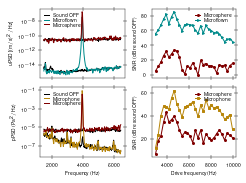

In [662]:
CXs = Cbd_fls
CX0 = Cbd_fl0
CYs = Cfls
CY0 = Cfl0
X_sty = sphere_sty
Y_sty = flown_sty
flown_labels = ["Microsphere", "Microflown"]
phone_labels = ["Microsphere", "Microphone"]




plot_fosis = np.arange(0, len(foss), 1)
plot_fosis = [4]
Df = 5000


fig, axs  = plt.subplots(2, 2, figsize=(3.375, 2.5), sharex="col")
SNRs_fl = SNR_pair(foss, Cbd_fls, Cbd_fl0, sphere_sty, Cfls, Cfl0, flown_sty, flown_labels, Df, axs[0,:], plot_fosis=plot_fosis)
SNRs_ph = SNR_pair(foss, Cbd_phs, Cbd_ph0, sphere_sty, Cphs, Cph0, phone_sty, phone_labels, Df, axs[1,:], plot_fosis=plot_fosis)


for snr, sty, label in zip(SNRs_fl.T, [sphere_sty, flown_sty], flown_labels):
    axs[0,1].plot(1e3*foss, 10*np.log10(snr), label=label, ms=2, lw=1,**sty)
    
for snr, sty, label in zip(SNRs_ph.T, [sphere_sty, phone_sty], phone_labels):
    axs[1,1].plot(1e3*foss, 10*np.log10(snr), label=label, ms=2, lw=1,**sty)

axs[0,0].legend(frameon=False, handlelength=1, loc="upper left", labelspacing=0)
axs[1,0].legend(frameon=False, handlelength=1, loc="upper left", labelspacing=0)
axs[0,1].legend(frameon=False,handlelength=1, loc="upper right", labelspacing=0)
axs[1,1].legend(frameon=False, handlelength=1, loc="upper right", labelspacing=0)
    


    
axs[0,0].set_ylabel(r"uPSD ${\rm [(m/s)^2/Hz]}$")
axs[1,0].set_ylabel(r"pPSD ${\rm (Pa^2/Hz)}$")
axs[1,0].set_xlabel("Frequency (Hz)")
axs[1,1].set_ylabel("SNR (dB re sound OFF)")
axs[0,1].set_ylabel("SNR (dB re sound OFF)")
axs[1,1].set_xlabel("Drive frequency (Hz)")
plt.tight_layout()
plt.savefig("figures/4kHz-CW_SNR.pdf")
plt.savefig("figures/4kHz-CW_SNR.png", dpi=600)

In [663]:
fnames_fl = sort_fnames(find_files(experiment_ders[-2]))
fnames_ph = sort_fnames(find_files(experiment_ders[3]))
Cbd_phs, Cphs, foss = load_many_psd(fnames_ph, bd_ph_params, ph_params, taumax=taumax)   
Cbd_fls, Cfls, foss = load_many_psd(fnames_fl, bd_fl_params, fl_params, taumax=taumax)

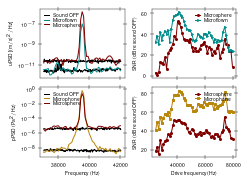

In [664]:
CXs = Cbd_fls
CX0 = Cbd_fl0
CYs = Cfls
CY0 = Cfl0
X_sty = sphere_sty
Y_sty = flown_sty
flown_labels = ["Microsphere", "Microflown"]
phone_labels = ["Microsphere", "Microphone"]




plot_fosis = np.arange(0, len(foss), 1)
plot_fosis = [13]
Df = 5000


fig, axs  = plt.subplots(2, 2, figsize=(3.375, 2.5), sharex="col")
SNRs_fl = SNR_pair(foss, Cbd_fls, Cbd_fl0, sphere_sty, Cfls, Cfl0, flown_sty, flown_labels, Df, axs[0,:], plot_fosis=plot_fosis)
SNRs_ph = SNR_pair(foss, Cbd_phs, Cbd_ph0, sphere_sty, Cphs, Cph0, phone_sty, phone_labels, Df, axs[1,:], plot_fosis=plot_fosis)


for snr, sty, label in zip(SNRs_fl.T, [sphere_sty, flown_sty], flown_labels):
    axs[0,1].plot(1e3*foss, 10*np.log10(snr), label=label, ms=2, lw=1,**sty)
    
for snr, sty, label in zip(SNRs_ph.T, [sphere_sty, phone_sty], phone_labels):
    axs[1,1].plot(1e3*foss, 10*np.log10(snr), label=label, ms=2, lw=1,**sty)

axs[0,0].legend(frameon=False, handlelength=1, loc="upper left", labelspacing=0)
axs[1,0].legend(frameon=False, handlelength=1, loc="upper left", labelspacing=0)
axs[0,1].legend(frameon=False,handlelength=1, loc="upper right", labelspacing=0)
axs[1,1].legend(frameon=False, handlelength=1, loc="upper right", labelspacing=0)
    


    
axs[0,0].set_ylabel(r"uPSD ${\rm [(m/s)^2/Hz]}$")
axs[1,0].set_ylabel(r"pPSD ${\rm (Pa^2/Hz)}$")
axs[1,0].set_xlabel("Frequency (Hz)")
axs[1,1].set_ylabel("SNR (dB re sound OFF)")
axs[0,1].set_ylabel("SNR (dB re sound OFF)")
axs[1,1].set_xlabel("Drive frequency (Hz)")
plt.tight_layout()
plt.savefig("figures/40kHz-CW_SNR.pdf")
plt.savefig("figures/40kHz-CW_SNR.png", dpi=600)

In [665]:
fnames_fl = sort_fnames(find_files(experiment_ders[-5]))
fnames_ph = sort_fnames(find_files(experiment_ders[-1]))
Cbd_phs, Cphs, foss = load_many_psd(fnames_ph, bd_ph_params, ph_params, taumax=taumax)   
Cbd_fls, Cfls, foss = load_many_psd(fnames_fl, bd_fl_params, fl_params, taumax=taumax)

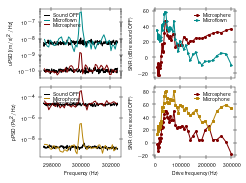

In [666]:
CXs = Cbd_fls
CX0 = Cbd_fl0
CYs = Cfls
CY0 = Cfl0
X_sty = sphere_sty
Y_sty = flown_sty
flown_labels = ["Microsphere", "Microflown"]
phone_labels = ["Microsphere", "Microphone"]




plot_fosis = np.arange(0, len(foss), 1)
plot_fosis = [50-1]
Df = 5000


fig, axs  = plt.subplots(2, 2, figsize=(3.375, 2.5), sharex="col")
SNRs_fl = SNR_pair(foss, Cbd_fls, Cbd_fl0, sphere_sty, Cfls, Cfl0, flown_sty, flown_labels, Df, axs[0,:], plot_fosis=plot_fosis)
SNRs_ph = SNR_pair(foss, Cbd_phs, Cbd_ph0, sphere_sty, Cphs, Cph0, phone_sty, phone_labels, Df, axs[1,:], plot_fosis=plot_fosis)


for snr, sty, label in zip(SNRs_fl.T, [sphere_sty, flown_sty], flown_labels):
    axs[0,1].plot(1e3*foss, 10*np.log10(snr), label=label, ms=2, lw=1,**sty)
    
for snr, sty, label in zip(SNRs_ph.T, [sphere_sty, phone_sty], phone_labels):
    axs[1,1].plot(1e3*foss, 10*np.log10(snr), label=label, ms=2, lw=1,**sty)

axs[0,0].legend(frameon=False, handlelength=1, loc="upper left", labelspacing=0)
axs[1,0].legend(frameon=False, handlelength=1, loc="upper left", labelspacing=0)
axs[0,1].legend(frameon=False,handlelength=1, loc="upper right", labelspacing=0)
axs[1,1].legend(frameon=False, handlelength=1, loc="upper right", labelspacing=0)
    


    
axs[0,0].set_ylabel(r"uPSD ${\rm [(m/s)^2/Hz]}$")
axs[1,0].set_ylabel(r"pPSD ${\rm (Pa^2/Hz)}$")
axs[1,0].set_xlabel("Frequency (Hz)")
axs[1,1].set_ylabel("SNR (dB re sound OFF)")
axs[0,1].set_ylabel("SNR (dB re sound OFF)")
axs[1,1].set_xlabel("Drive frequency (Hz)")
plt.tight_layout()
plt.savefig("figures/40kHz-wide-CW_SNR.pdf")
plt.savefig("figures/40kHz-wide-CW_SNR.png", dpi=600)

In [667]:
Cphs[0].T[:]

array([23.16974191, 23.16893858, 23.1677541 , 23.16748437, 23.1681587 ])